# RAG sur les Aphorismes d'Hippocrate

## 1. 📘 Introduction

Ce notebook propose une approche méthodologique pour extraire, nettoyer et structurer les *Aphorismes* d'Hippocrate à partir d'une édition ancienne numérisée au format PDF. L’objectif final est de préparer ces textes en vue de leur intégration dans un système de **RAG** (*Retrieval-Augmented Generation*), permettant ainsi d’en faciliter l’analyse et l’interprétation par des modèles de langage moderne.

### 📄 Source du document
- **Titre** : *Aphorismes d'Hippocrate*, traduits en français par Émile Littré  
- **Éditeur** : J.-B. Baillière  
- **Lieu** : Paris  
- **Année** : 1844  
- **Format numérique** : PDF (numérisation d’un ouvrage ancien)

### 🔍 Champ d’étude
Seule la **traduction française** des *Aphorismes* nous intéresse ici. Elle est reprise dans le document PDF entre les **pages 96 et 260**, et constitue la base du corpus à traiter dans ce projet.


Positionnment à la racine du répertoire du projet.

In [1]:
%pwd
import os
os.chdir("..")
%pwd

'/Users/micheldpd/Projects/rag_aph_hippocrate'



## 2. Configuration de l'environnement

Commençons par importer les bibliothèques nécessaires et configurer le logging.

In [2]:
import fitz  # PyMuPDF
import re
import logging
import json
import time
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

# Configuration du logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('aphorism_extractor')

## 3. Extraction des textes du PDF

Le premier défi consiste à extraire correctement le texte du PDF, qui présente des caractéristiques propres aux livres anciens numérisés: mots coupés en fin de ligne, structure irrégulière, etc.

### 3.1 Nettoyage des tirets en fin de ligne

In [3]:
def remove_hyphens(text: str) -> str:
    """Supprime les '-' en fin de ligne et fusionne les mots coupés."""
    lines = text.splitlines()
    cleaned_lines = []
    i = 0
    while i < len(lines):
        line = lines[i].rstrip()
        if line.endswith('-'):
            # Enlever le '-', prendre le mot sans tiret
            word_part = line[:-1]
            if i + 1 < len(lines):
                next_line = lines[i + 1].lstrip()
                # Si la ligne suivante commence par une lettre minuscule, c'est probablement la suite
                if next_line and next_line[0].islower():
                    line = word_part + next_line
                    i += 1  # sauter la prochaine ligne
                else:
                    line = word_part + next_line
                    i += 1
            else:
                line = word_part
        cleaned_lines.append(line)
        i += 1
    return "\n".join(cleaned_lines)

### 3.2 Correction des formats de numérotation

Un Aphorisme, dans le document source analysé commence par un nombre à deux chiffres maximum suivi d'un point ou d'une virgule. En effet, lors de l'extraction de text du pdf certain points sont transformés en virgule. 

In [4]:
def replace_comma_after_number(line_text: str) -> str:
    """Remplace les virgules après un numéro par un point (pour normaliser la numérotation)."""
    return re.sub(r'^(\d{1,2}),', r'\1.', line_text)

### 3.3 Extraction des paragraphes par page

Nous retenons uniquement le texte principal des Aphorismes , en omettant les notes de bas de page qui peuvent parfois représenter un volume significatif. Afin de distinguer le corps du texte des notes, nous segmentons chaque page en paragraphes à l’aide de MyMuPDF , en nous appuyant notamment sur les espaces entre lignes (interlignes) pour identifier les séparations entre éléments textuels.



In [5]:
def extract_until_nth_paragraph(page: fitz.Page, n: int = 2, line_gap_threshold: float = 1.8):
    """
    Extrait le texte jusqu'au n-ième paragraphe d'une page.
    Détecte les paragraphes selon l'espacement vertical entre les lignes.
    
    Args:
        page: Page PyMuPDF
        n: Nombre de paragraphes à extraire
        line_gap_threshold: Facteur multiplicateur pour l'espacement qui définit un nouveau paragraphe
    
    Returns:
        Texte extrait jusqu'au n-ème paragraphe
    """
    text_dict = page.get_text("dict")
    blocks = text_dict["blocks"]
    lines = []
    last_y = None
    avg_line_height = 0
    paragraph_count = 1
    start_extraction = False  # On attend la première ligne valide (>=15 caractères)
    
    for block in blocks:
        if "lines" in block:
            for line in block["lines"]:
                y = line["bbox"][1]
                line_text = " ".join(span["text"] for span in line["spans"]).strip()

                # === FILTRE : ignorer les lignes vides ou trop courtes (< 2)
                if not line_text or len(line_text) < 2:
                    continue

                # === ATTENTE DE LA PREMIÈRE LIGNE LONGUE (>=15) ===
                if not start_extraction:
                    if len(line_text) >= 15:
                        start_extraction = True  # C'est ici qu'on commence
                        line_text = replace_comma_after_number(line_text)
                        lines.append(line_text)
                else:
                    # === EXTRACTION NORMALE APRÈS LE DÉMARRAGE ===
                    line_text = replace_comma_after_number(line_text)
                    if last_y is not None:
                        gap = y - last_y
                        if gap > line_gap_threshold * avg_line_height:
                            paragraph_count += 1
                            if paragraph_count > n:
                                return "\n".join(lines)
                            lines.append("\n" + line_text)
                        else:
                            lines.append(line_text)
                    else:
                        lines.append(line_text)
                # Mise à jour pour la prochaine ligne
                last_y = y
                avg_line_height = line["bbox"][3] - line["bbox"][1]
                
    return "\n".join(lines)

### 3.4 Traitement du PDF complet

In [6]:
def process_test_part2(pdf_path: str, start_page: int = 96, end_page: int = 260):
    """
    Traite une section du PDF contenant les aphorismes.
    
    Args:
        pdf_path: Chemin vers le fichier PDF
        start_page: Numéro de la première page à traiter
        end_page: Numéro de la dernière page à traiter
        
    Returns:
        Dictionnaire {numéro_page: texte_extrait}
    """
    doc = fitz.open(pdf_path)
    results = {}
    
    for page_num in range(start_page, end_page): 
        # Vérifier si la page est paire (numéro de page impair en 0-indexé)
        if (page_num) % 2 == 0:  # On ne traite que les pages paires (contenant le texte principal)
            page = doc.load_page(page_num)

            # Déterminer la valeur de n selon les règles spécifiques au livre
            current_page_number = page_num
            if current_page_number in [100]:
                n_val = 3
            elif current_page_number in [110, 128, 146, 176, 190]:
                n_val = 4
            else:
                n_val = 2
                
            # Extraction du texte
            text = extract_until_nth_paragraph(page, n=n_val)
            text = remove_hyphens(text)  # Supprimer les tirets
            results[current_page_number] = text
            
    doc.close()
    return results

## 4. Extraction des aphorismes

Une fois le texte extrait des pages, nous devons identifier et extraire chaque aphorisme numéroté.

### 4.1 Extraction des aphorismes d'une page

In [7]:
def extract_aphorisms(page_data: dict, all_texts: dict) -> list[dict]:
    """
    Extrait tous les aphorismes à partir d'un texte extrait de page.
    Gère les cas où un aphorisme est coupé sur une autre page (page x+2).

    Args:
        page_data (dict): {'page_num', 'section', 'text'}
        all_texts (dict): {page_num: text}, pour chercher les suites

    Returns:
        list[dict]: Liste d'aphorismes trouvés
    """
    results = []
    current_page = page_data["page_num"]
    lines = [line.strip() for line in page_data["text"].splitlines() if line.strip()]
    
    logger.info(f"Traitement de la page {current_page} avec {len(lines)} lignes")
    
    # On commence à partir de la 2ème ligne
    start_idx = min(1, len(lines) - 1)
    
    # Traitement des aphorismes sur la page courante
    aphorisms_current_page = _process_current_page_aphorisms(lines, start_idx, current_page, page_data["section"])
    
    # Traitement des aphorismes qui continuent sur la page x+2
    final_results = _handle_cross_page_aphorisms(aphorisms_current_page, current_page, all_texts, page_data["section"])
    
    return final_results

### 4.2 Traitement des aphorismes sur une page

In [8]:
def _process_current_page_aphorisms(lines: list, start_idx: int, current_page: int, first_line: str) -> list:
    """
    Traite les aphorismes sur la page courante.
    
    Args:
        lines (list): Liste des lignes de texte
        start_idx (int): Index de départ pour le traitement
        current_page (int): Numéro de la page courante
        first_line (str): Première ligne de la page pour référence
        
    Returns:
        list: Liste contenant les aphorismes complets et le dernier incomplet s'il existe
    """
    results = []
    i = start_idx
    current_number = None
    current_text = ""
    
    while i < len(lines):
        line = lines[i]
        
        # Détection d'un nouveau numéro d'aphorisme
        match = re.match(r"^(\d{1,2})[.,]\s*(.*)", line)
        if match:
            if current_number is not None:
                # Finir l'aphorisme précédent
                results.append({
                    "page": current_page,
                    "section": first_line,
                    "aphorism_number": current_number,
                    "text": current_text.strip(),
                    "status": "complete"  # Par défaut, on suppose qu'il est complet
                })
                logger.debug(f"Aphorisme {current_number} terminé sur la page {current_page}")
                current_text = ""
            
            # Nouveau numéro détecté
            current_number = match.group(1).zfill(2)
            current_text = match.group(2).strip() + " "
            logger.debug(f"Nouvel aphorisme {current_number} détecté sur la page {current_page}")
        elif current_number is not None:
            # Continuation du texte
            current_text += line.strip() + " "
        
        i += 1
    
    # Ajouter le dernier aphorisme s'il existe
    if current_number and current_text.strip():
        results.append({
            "page": current_page,
            "section": first_line,
            "aphorism_number": current_number,
            "text": current_text.strip(),
            "status": "potentially_incomplete"  # Il pourrait continuer sur une autre page
        })
        logger.debug(f"Aphorisme {current_number} potentiellement incomplet à la fin de la page {current_page}")
    
    return results

### 4.3 Gestion des aphorismes coupés entre pages

In [10]:
def _handle_cross_page_aphorisms(aphorisms: list, current_page: int, all_texts: dict, first_line: str) -> list:
    """
    Traite les aphorismes qui pourraient continuer sur la page x+2.
    
    Args:
        aphorisms (list): Liste des aphorismes de la page courante
        current_page (int): Numéro de la page courante
        all_texts (dict): Dictionnaire de tous les textes par page
        first_line (str): Première ligne de la page pour référence
        
    Returns:
        list: Liste mise à jour des aphorismes
    """
    if not aphorisms:
        return []
    
    # Tous les aphorismes sauf le dernier sont complets
    complete_aphorisms = aphorisms[:-1]
    
    # Vérifier si le dernier aphorisme continue sur la page x+2
    last_aphorism = aphorisms[-1]
    if last_aphorism["status"] == "potentially_incomplete":
        next_page = current_page + 2
        
        if next_page in all_texts:
            logger.info(f"Vérification de la continuation de l'aphorisme {last_aphorism['aphorism_number']} sur la page {next_page}")
            
            next_text = all_texts[next_page]
            next_lines = [line.strip() for line in next_text.splitlines() if line.strip()]
            
            # Déterminer si cet aphorisme continue sur la page suivante
            continuation_text = _find_aphorism_continuation(next_lines[1:], last_aphorism["aphorism_number"])
            
            if continuation_text:
                # Mettre à jour le texte de l'aphorisme avec sa continuation
                last_aphorism["text"] += " " + continuation_text
                last_aphorism["status"] = "cross_page_complete"
                logger.info(f"Aphorisme {last_aphorism['aphorism_number']} complété à travers les pages {current_page} et {next_page}")
            else:
                last_aphorism["status"] = "complete"
        else:
            logger.warning(f"Page suivante {next_page} non disponible pour vérifier la continuation de l'aphorisme {last_aphorism['aphorism_number']}")
            last_aphorism["status"] = "complete"  # On le considère complet par défaut
    
    # Nettoyer les statuts avant de retourner les résultats
    for aphorism in complete_aphorisms + [last_aphorism]:
        aphorism.pop("status", None)
    
    return complete_aphorisms + [last_aphorism]

### 4.4 Recherche de la continuation d'un aphorisme

In [11]:
def _find_aphorism_continuation(next_lines: list, current_number: str) -> str:
    """
    Cherche la continuation d'un aphorisme sur la page suivante.
    
    Args:
        next_lines (list): Liste des lignes sur la page suivante
        current_number (str): Numéro de l'aphorisme courant
        
    Returns:
        str: Texte de continuation ou chaîne vide si aucune continuation trouvée
    """
    continuation_text = ""
    
    # On commence à la deuxième ligne pour ignorer potentiellement l'en-tête
    j = 1
    while j < len(next_lines):
        line = next_lines[j]
        logger.debug(f"Examen de la ligne pour continuation: {line}")
        
        # Détection d'un nouveau numéro sur la page suivante
        match = re.match(r"^(\d{1,2})\.\s*(.*)", line)
        if match:
            # Un nouvel aphorisme commence, donc fin de la continuation
            break
        else:
            # Ajout du texte à la continuation
            continuation_text += " " + line.strip()
        j += 1
    
    return continuation_text.strip()

### 4.5 Fonction utilitaire: Normalisation des numéros de section

In [12]:
def normalize_sections(ligne):
    # Dictionnaire de correspondance
    remplacements = {
        'PR': 'SECTION.1',
        'DEU': 'SECTION.2',
        'TRO': 'SECTION.3',
        'QUA': 'SECTION.4',
        'CIN': 'SECTION.5',
        'SIX': 'SECTION.6',
        'SEP': 'SECTION.7',
        'BEP': 'SECTION.7'
    }

    # Nettoyer la ligne pour faciliter la recherche
    ligne_nettoyee = ligne.strip()

    # Vérifier si l'un des mots-clés est présent
    for mot, section in remplacements.items():
        if mot in ligne_nettoyee:
            return section

    # Si aucun mot-clé trouvé, retourner la ligne originale
    return ligne

In [13]:
normalize_sections("ccc PREMIERE SECTION vvv")

'SECTION.1'

### 4.6 Extraction des aphorismes à travers toutes les pages

In [14]:
def extract_aphorisms_across_pages(extracted_texts: dict) -> list[dict]:
    """
    Extrait tous les aphorismes à travers toutes les pages traitées.
    
    Args:
        extracted_texts (dict): Dictionnaire {page_num: texte} des textes extraits
        
    Returns:
        list: Liste de tous les aphorismes extraits
    """
    all_aphorisms = []
    sorted_pages = sorted(extracted_texts.keys())
    
    logger.info(f"Début du traitement de {len(sorted_pages)} pages")
    
    for page_num in sorted_pages:
        text = extracted_texts[page_num]
        
        # Vérification que le texte contient au moins une ligne
        if not text.strip():
            logger.warning(f"Page {page_num} vide ou sans contenu valide, ignorée")
            continue
            
        lines = text.splitlines()
        if not lines:
            logger.warning(f"Page {page_num} sans lignes valides, ignorée")
            continue
            
        first_line = normalize_sections(lines[0].strip())

        page_data = {
            "page_num": page_num,
            "section": first_line,
            "text": text
        }

        logger.info(f"Traitement de la page {page_data['page_num']} (original: {page_num})")
        aphorisms = extract_aphorisms(page_data, extracted_texts)
        
        if aphorisms:
            logger.info(f"Page {page_data['page_num']}: {len(aphorisms)} aphorismes extraits")
            all_aphorisms.extend(aphorisms)
        else:
            logger.info(f"Page {page_data['page_num']}: aucun aphorisme trouvé")

    logger.info(f"Extraction terminée: {len(all_aphorisms)} aphorismes au total")

    # Enregistrement des résultats dans un fichier JSON
    with open("data/aphorisms_extracted.json", "w", encoding="utf-8") as f:
        json.dump(all_aphorisms, f, ensure_ascii=False, indent=4)
    logger.info("Aphorismes extraits enregistrés dans 'data/aphorisms_extracted.json'")
    return all_aphorisms

### 4.7 Affichage des aphorismes pour vérification

In [15]:
def display_aphorisms(aphorisms: list) -> None:
    """
    Affiche les aphorismes extraits pour vérification.
    
    Args:
        aphorisms (list): Liste des aphorismes à afficher
    """
    for aph in aphorisms:
        print(f" {aph['section']} | Aphorisme {aph['aphorism_number']} | Page {aph['page']} | longueur_aph: {len(aph['text'])}")
        print(f"{aph['text']}\n")

## 5. Pipeline complet

Utilisons maintenant toutes ces fonctions dans un pipeline complet pour extraire et corriger les aphorismes d'Hippocrate.

In [16]:
# Chemin du fichier PDF
pdf_path = "km/aphorismes_hippocrate.pdf"
    
# 1. Extraction des textes
print("Étape 1: Extraction des textes du PDF...")
extracted_texts = process_test_part2(pdf_path, start_page=96, end_page=260)
print(f"  - {len(extracted_texts)} pages traitées")
    
# 2. Extraction des aphorismes
print("\nÉtape 2: Extraction des aphorismes...")
all_aphorisms = extract_aphorisms_across_pages(extracted_texts)
print(f"{len(all_aphorisms)} aphorismes extraits")
    
# 3. Affichage d'un échantillon pour vérification
print("\nÉtape 3: Vérification d'un échantillon...")
sample_size = min(5, len(all_aphorisms))
display_aphorisms(all_aphorisms[:sample_size])

Étape 1: Extraction des textes du PDF...


2025-05-12 10:15:04,048 - INFO - Début du traitement de 82 pages
2025-05-12 10:15:04,048 - INFO - Traitement de la page 96 (original: 96)
2025-05-12 10:15:04,048 - INFO - Traitement de la page 96 avec 19 lignes
2025-05-12 10:15:04,049 - INFO - Vérification de la continuation de l'aphorisme 03 sur la page 98
2025-05-12 10:15:04,049 - INFO - Aphorisme 03 complété à travers les pages 96 et 98
2025-05-12 10:15:04,049 - INFO - Page 96: 3 aphorismes extraits
2025-05-12 10:15:04,049 - INFO - Traitement de la page 98 (original: 98)
2025-05-12 10:15:04,049 - INFO - Traitement de la page 98 avec 11 lignes
2025-05-12 10:15:04,050 - INFO - Page 98: aucun aphorisme trouvé
2025-05-12 10:15:04,050 - INFO - Traitement de la page 100 (original: 100)
2025-05-12 10:15:04,050 - INFO - Traitement de la page 100 avec 15 lignes
2025-05-12 10:15:04,050 - INFO - Vérification de la continuation de l'aphorisme 05 sur la page 102
2025-05-12 10:15:04,050 - INFO - Page 100: 2 aphorismes extraits
2025-05-12 10:15:04

  - 82 pages traitées

Étape 2: Extraction des aphorismes...
390 aphorismes extraits

Étape 3: Vérification d'un échantillon...
 SECTION.1 | Aphorisme 01 | Page 96 | longueur_aph: 313
La  vie  est  courte,  l’art.est  long,  l’occasion fugitive,  l'expérience  trompeuse,  le  jugement  difficile.  1]  faut  non-seulement  faire  soi-même  ce  qui convient,  mais  encore  faire  que  le  malade,  les  assistants  et  les  choses extérieures  y  concourent (ἔξ.  τυ  τ  p.096,  LT:  Ép.  VE,  9%

 SECTION.1 | Aphorisme 02 | Page 96 | longueur_aph: 628
Si  dans  les  dérangements  abdominaux  et  dans les  vomissements  qui  surviennent  spontanément, ce  qui  doit  être  évacué  est  évacué, ils  sont  utiles, et  les  malades  les  supportent  facilement  ;  sinon, c’est  le  contraire  (1,  25).  Il  en  est  de  même  des  évacuations  [artificielles];  si  elles  sont  telles  qu’elles doivent  être,  elles  sont  utiles  et  les  malades  les supportent  facilement;  sinon,  c’est  l

## 6. Analyse des résultats

Une fois les aphorismes extraits et corrigés, nous pouvons effectuer quelques analyses pour valider la qualité des données.

Nombre total d'aphorismes: 390
Longueur moyenne: 185.8 caractères
Longueur min: 36 caractères
Longueur max: 1387 caractères


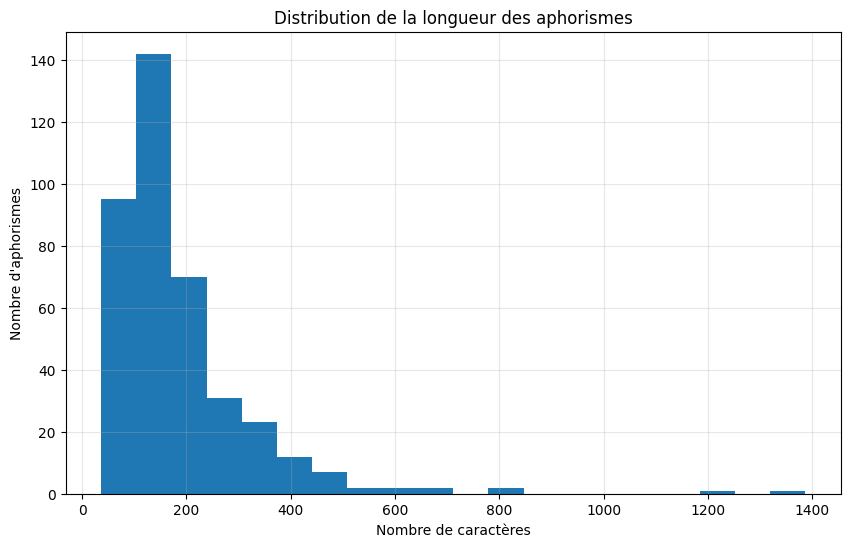

In [21]:
def analyze_results(json_file="data/aphorisms_extracted.json"):
    """
    Analyse les résultats extraits et corrigés des aphorismes.  
    """
    # Chargement des données corrigées
    with open(json_file, "r", encoding="utf-8") as f:
        aphorismes = json.load(f)
    
    # Statistiques de base
    nb_aphorismes = len(aphorismes)
    longueurs = [len(a["text"]) for a in aphorismes]
    longueur_moyenne = sum(longueurs) / nb_aphorismes if nb_aphorismes > 0 else 0
    longueur_min = min(longueurs) if longueurs else 0
    longueur_max = max(longueurs) if longueurs else 0
    
    print(f"Nombre total d'aphorismes: {nb_aphorismes}")
    print(f"Longueur moyenne: {longueur_moyenne:.1f} caractères")
    print(f"Longueur min: {longueur_min} caractères")
    print(f"Longueur max: {longueur_max} caractères")
    
    # Distribution des longueurs
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.hist(longueurs, bins=20)
    plt.title("Distribution de la longueur des aphorismes")
    plt.xlabel("Nombre de caractères")
    plt.ylabel("Nombre d'aphorismes")
    plt.grid(True, alpha=0.3)
    plt.show
    # plt.savefig("distribution_longueurs.png")
    # plt.close()


analyze_results()

## 8. Préparation pour le système RAG

Pour intégrer ces aphorismes dans un système RAG, il est essentiel de les formatter correctement afin de faciliter leur traitement. Cela implique notamment de segmenter les textes trop longs (dépassant 500 caractères) ainsi que ceux de moins de 500 caractères, en prévision des étapes d’embedding, de construction de l’index et d’incorporation dans le contexte lors de l’appel au modèle de langage (LLM).

In [18]:

def create_document(aphorism, part_suffix="", text_slice=slice(None)):
    """
    Helper to create a document entry.
    """
    return {
        "id": f"s{aphorism['section'][-1]}.aph_{aphorism['aphorism_number']}{part_suffix}.p{aphorism['page']}",
        "text": aphorism["text"][text_slice],
        "metadata": {
            "source": "Hippocrate, Aphorismes",
            "section": aphorism["section"],
            "aphorism_number": f"{aphorism['aphorism_number']}{part_suffix}",
            "page": aphorism["page"],
            "category": "medical_ancient_text"
        }
    }


In [19]:

def prepare_for_rag(
    input_path="data/aphorisms_extracted.json",
    output_path="data/hippocrate_rag_data.json",
    short_limit=450,
    medium_limit=800
):
    with open(input_path, "r", encoding="utf-8") as f:
        aphorismes = json.load(f)

    rag_documents = []

    for aph in aphorismes:
        text = aph["text"]
        length = len(text)

        if length <= short_limit:
            # Single short aphorism
            rag_documents.append(create_document(aph))

        elif length <= medium_limit:
            # Split into two parts
            mid = length // 2
            rag_documents.append(create_document(aph, "_1", slice(mid)))
            rag_documents.append(create_document(aph, "_2", slice(mid - 30, None)))

        else:
            # Split into three parts
            ter = length // 3
            rag_documents.append(create_document(aph, "_1", slice(ter)))
            rag_documents.append(create_document(aph, "_2", slice(ter - 30, 2 * ter)))
            rag_documents.append(create_document(aph, "_3", slice(2 * ter - 30, None)))

    # Add introduction document
    intro_doc = {
        "id": "hippocrate_intro",
        "text": (
            "Les Aphorismes d'Hippocrate sont une collection de maximes médicales attribuées "
            "à Hippocrate de Cos (environ 460-370 av. J.-C.), considéré comme le père de la "
            "médecine occidentale. Ces courts énoncés résument les observations cliniques et "
            "les principes thérapeutiques de l'époque, formant une base importante de la "
            "pensée médicale pendant des siècles."
        ),
        "metadata": {
            "source": "Aphorismes d'Hippocrate*, traduits en français par Émile Littré , 1844",
            "category": "context"
        }
    }
    rag_documents.append(intro_doc)

    # Save to file
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(rag_documents, f, ensure_ascii=False, indent=4)

    print(f"{len(rag_documents)} documents préparés pour le système RAG")

# Run the function
prepare_for_rag()

409 documents préparés pour le système RAG


Nombre total d'aphorismes: 409
Longueur moyenne: 179.4 caractères
Longueur min: 36 caractères
Longueur max: 493 caractères


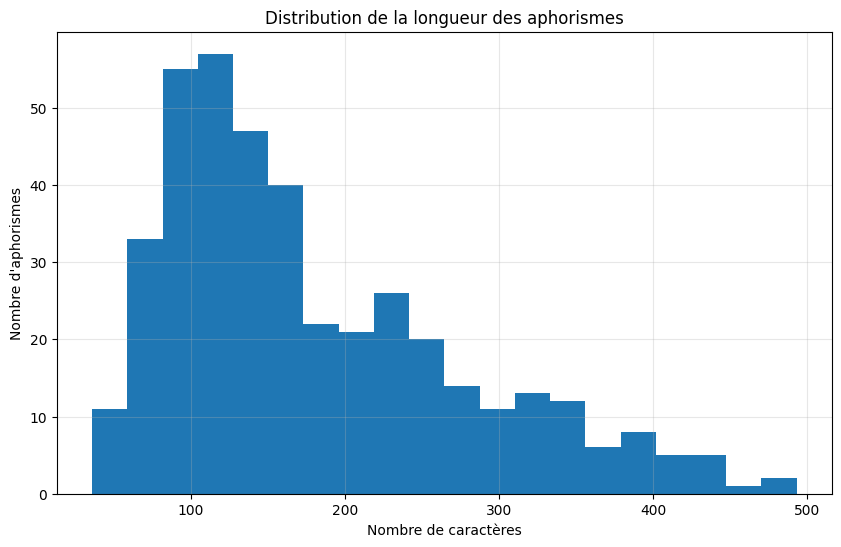

In [22]:
analyze_results("data/hippocrate_rag_data.json")

## 9. Conclusion et perspectives

Ce notebook a présenté une méthode complète pour:
1. Extraire des textes d'un PDF ancien avec une structure complexe
2. Identifier et structurer les aphorismes d'Hippocrate
3. Préparer les données pour un système RAG

### Points forts de l'approche:

- Gestion des spécificités des livres anciens (mots coupés, structure non standard)
- Traitement des aphorismes à cheval sur plusieurs pages
- Pipeline modulaire et extensible

### Pistes d'amélioration:
- Utilisation d'un LLM pour la correction du texte tout en préservant le style
- Sauvegarde progressive des données pendant le traitement
- Ajouter une étape de validation manuelle pour les corrections proposées par le LLM
- Incorporer des métadonnées supplémentaires (catégorisation thématique des aphorismes)
- Optimiser les requêtes au LLM pour réduire les temps d'attente
- Ajouter un système de détection des erreurs d'OCR plus sophistiqué
- Étendre la méthode à d'autres textes médicaux historiques

### Applications possibles:

- Assistant médical historique pour les chercheurs en histoire de la médecine
- Outil pédagogique pour les étudiants en médecine
- Interface de recherche sémantique pour explorer l'héritage d'Hippocrate
- Base pour la comparaison avec d'autres textes médicaux anciens

Ce notebook fournit un cadre méthodologique qui peut être adapté à d'autres textes anciens numérisés, contribuant ainsi à la préservation et à l'accessibilité du patrimoine médical historique.